In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

from solar_energy_forecast.preprocess import get_data
from solar_energy_forecast.pvlib import get_relative_airmass

## EDA

In [5]:
df = get_data(verbose=True).dropna()



## PV data:
                  count      mean       std  min     50%     max
relative_power  20019.0  0.237823  0.253717  0.0  0.1319  1.0169

## Solar data:
                      count     mean     std     min      50%      max
DHI                 43824.0    62.52   93.97    0.00     0.00   476.00
DNI                 43824.0   192.04  308.79    0.00     0.00  1029.00
GHI                 43824.0   167.16  252.45    0.00     0.00  1022.00
Clearsky DHI        43824.0    48.26   59.40    0.00     0.00   416.00
Clearsky DNI        43824.0   327.65  367.59    0.00     0.00  1029.00
Clearsky GHI        43824.0   227.65  300.72    0.00     0.00  1022.00
Cloud Type          43824.0     3.42    3.05    0.00     4.00    10.00
Dew Point           43824.0     6.72    8.95  -19.00     7.00    24.00
Solar Zenith Angle  43824.0    89.68   35.05   18.95    89.57   161.15
Fill Flag           43824.0     1.93   11.52    0.00     0.00   100.00
Surface Albedo      43824.0     0.23    0.26    0.11     0.1

<Axes: xlabel='Cloud Type', ylabel='relative_power'>

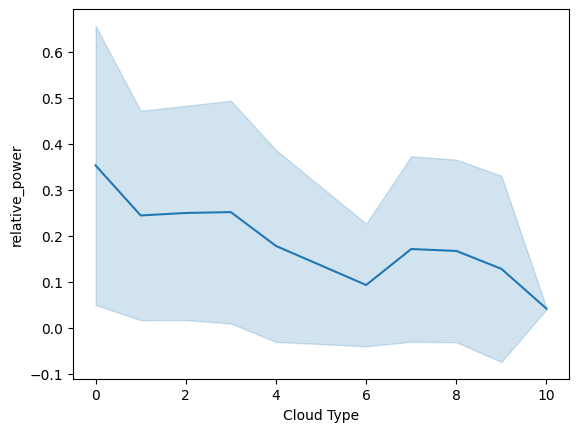

In [167]:
sns.lineplot(df, y="relative_power", x="Cloud Type", errorbar="sd")

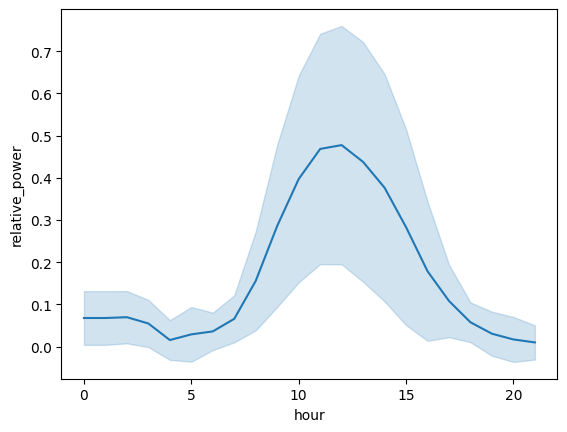

In [6]:
df["hour"] = df.index.hour
sns.lineplot(df, y="relative_power", x="hour", errorbar="sd")
plt.savefig('output/relative_power_by_hour.png')

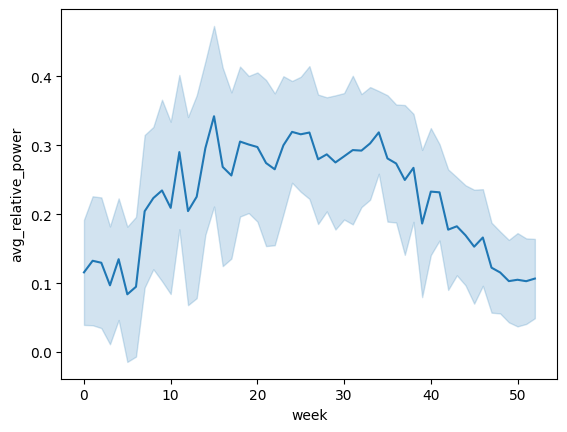

In [7]:
df["day_of_year"] = df.index.day_of_year
df["date"] = df.index.date
df["week"] = df.index.day_of_year // 7
sns.lineplot(
    df.groupby("date").agg(avg_relative_power=("relative_power", "mean"), week=("week", "first")),
    y="avg_relative_power", x="week", errorbar="sd", estimator='mean')
plt.savefig('output/avg_relative_power_by_week.png')

## Adding to the table

In [8]:
df["Water Pressure"] = df["Relative Humidity"] * 6.02949 * np.exp((17.625 * df["Temperature"]) / (df["Temperature"] + 253.04))
df["PVL Relative Airmass"] = get_relative_airmass(df["Solar Zenith Angle"])
# Pressure * PVL Relative Airmass
df["Airmass"] = df["Pressure"] * df["PVL Relative Airmass"]
# Water Pressure * PVL Relative Airmass
df["Watervapormass"] = df["Pressure"] * df["PVL Relative Airmass"]

In [9]:
df["sunrise"] = pd.to_datetime(df["sunrise"], format="%I:%M %p")
df["sunrise"] = df.index.normalize() + pd.to_timedelta(df["sunrise"].dt.hour, unit='h') + pd.to_timedelta(df["sunrise"].dt.minute, unit='m')
df["sunset"] = pd.to_datetime(df["sunset"], format="%I:%M %p")
df["sunset"] = df.index.normalize() + pd.to_timedelta(df["sunset"].dt.hour, unit='h') + pd.to_timedelta(df["sunset"].dt.minute, unit='m')

df["Suntime"] = (df.index.to_series() - df["sunrise"]).astype(int) * ((df.index.to_series() - df["sunset"])).astype(int)
df["Suntime"] = np.where(df["Suntime"] > 0, df["Suntime"], 0)

In [11]:
df["Day"] = df.index.day_of_year
df["Day"] /= 365
df["Cos of Day"] = np.cos(2 * np.pi * df["Day"])
df["Sin of Day"] = np.sin(2 * np.pi * df["Day"])

In [13]:
df.drop(columns=["sunrise", "sunset", "moonrise", "moonset", "Water Pressure", "PVL Relative Airmass", "Solar Zenith Angle", "location", "Day"])

,relative_power,DHI,DNI,GHI,Clearsky DHI,Clearsky DNI,Clearsky GHI,Cloud Type,Dew Point,Fill Flag,...,windspeedKmph,hour,day_of_year,date,week,Airmass,Watervapormass,Suntime,Cos of Day,Sin of Day
date_time,,,,,,,,,,,,,,,,,,,,,
2014-01-01 07:00:00,0.0079,0,0,0,0,0,0,1,-9.0,0,...,18,7,1,2014-01-01,0,NaN,NaN,0,0.999852,1.721336e-02
2014-01-01 08:00:00,0.1019,0,0,0,0,0,0,4,-9.0,0,...,20,8,1,2014-01-01,0,NaN,NaN,0,0.999852,1.721336e-02
2014-01-01 09:00:00,0.3932,0,0,0,0,0,0,4,-10.0,0,...,22,9,1,2014-01-01,0,NaN,NaN,0,0.999852,1.721336e-02
2014-01-01 10:00:00,0.5447,0,0,0,0,0,0,4,-10.0,0,...,21,10,1,2014-01-01,0,NaN,NaN,8266772738748710912,0.999852,1.721336e-02
2014-01-01 11:00:00,0.5485,0,0,0,0,0,0,1,-10.0,0,...,19,11,1,2014-01-01,0,NaN,NaN,7283969119152504832,0.999852,1.721336e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-31 12:00:00,0.1280,16,229,24,16,229,24,1,-14.0,0,...,26,12,365,2017-12-31,52,19573.964104,19573.964104,7337187446783737856,1.000000,-2.449294e-16
2017-12-31 13:00:00,0.1067,51,658,172,51,658,172,1,-14.0,0,...,26,13,365,2017-12-31,52,5348.387484,5348.387484,0,1.000000,-2.449294e-16
2017-12-31 14:00:00,0.0464,69,820,317,69,820,317,4,-15.0,4,...,26,14,365,2017-12-31,52,3310.870974,3310.870974,2505541966482112512,1.000000,-2.449294e-16


## Normalizing

In [8]:
def normalize(i:int, start: float, finish: float, distribution):
    curMin = df[i].min()
    df[i] = (finish-start)*(df[i] - curMin)/(df[i].max() - curMin) + start
    df[i].apply(func=distribution)

In [10]:
dist_dictionary = {i: lambda x: x for i in df.columns}
dist_dictionary.drop("relative_power", "yesterday", "Cloud Type", "Solar Zenith Angle", "sunHour", "sunrise", "sunset", "location")

TypeError: unhashable type: 'list'

In [ ]:
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
    
for i in dist_dictionary:
    if type(df[i][0]) != str:
        normalize(i, 0, 1, dist_dictionary[i])

## Training

In [14]:
X_train = df[df.index.year < 2017].select_dtypes(include='number').drop(columns="relative_power")
y_train = df[df.index.year < 2017]["relative_power"]

X_test = df[df.index.year == 2017].select_dtypes(include='number').drop(columns="relative_power")
y_test = df[df.index.year == 2017]["relative_power"]

In [15]:
clf = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=4,
    max_features='sqrt',
    random_state=42
)
clf.fit(X_train, y_train)

RandomForestRegressor(max_depth=15, max_features='sqrt', min_samples_leaf=4,
                      min_samples_split=10, n_estimators=200, random_state=42)

## Evaluation

In [16]:
def normalized_mean_squared_error(y_test, y_pred):
    return np.mean(
        mean_squared_error(y_test, y_pred, multioutput='raw_values') /
        np.max(np.stack([y_pred, y_test.to_numpy()]), axis=0)
    )

In [17]:
y_pred = clf.predict(X_test)
y_pred = np.where(y_pred > 0, y_pred, 0)

In [18]:
rmse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
normlized_rmse = normalized_mean_squared_error(y_test, y_pred)
{"RMSE": rmse, "MAE": mae, "nRMSE": float(normlized_rmse)}

{'RMSE': 0.00875658440390972,
 'MAE': 0.06729200629239801,
 'nRMSE': 0.09279808106330004}

## Hyperparamaters Comparison

In [117]:
for n in [15, 30, 45, 60, 75, 90]:
    clf_n = RandomForestRegressor(n_estimators=n)
    clf_n.fit(X_train, y_train)
    y_pred = clf_n.predict(X_test)
    y_pred = np.where(y_pred > 0, y_pred, 0)
    rmse_n = normalized_mean_squared_error(y_test, y_pred)
    print(f"{n}: {rmse_n}")

KeyboardInterrupt: 

## Analysis (for linear model only)

In [43]:
df_params = X_train.mean().rename("mean_value").to_frame()
df_params["coef"] = clf.coef_
df_params["mean_weight"] = df_params["coef"] * df_params["mean_value"]
df_params.sort_values("mean_weight", ascending=False, inplace=True)
df_params

,mean_value,coef,mean_weight
tempC,12.718451,0.041114,0.522905
Pressure,1007.321886,0.000393,0.396115
week,25.772214,0.008991,0.231710
windspeedKmph,15.877240,0.012486,0.198238
FeelsLikeC,11.132938,0.012404,0.138093
Relative Humidity,81.361089,0.001410,0.114713
sunHour,10.490147,0.003563,0.037377
HeatIndexC,13.139744,0.002766,0.036339
Clearsky DHI,68.015923,0.000497,0.033771
DNI,261.814861,0.000127,0.033306


<Axes: >

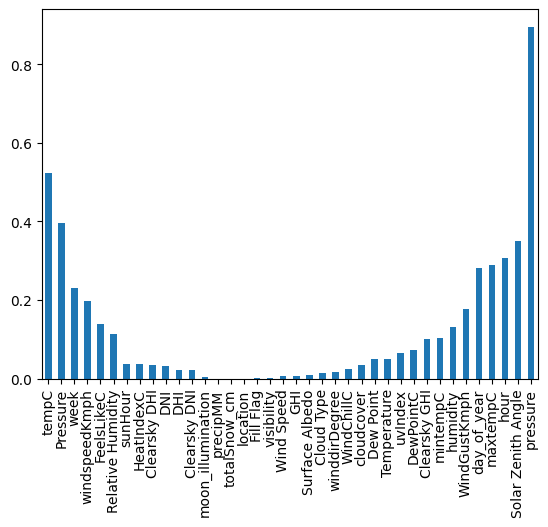

In [45]:
df_params["mean_weight"].abs().plot(kind="bar")